<a href="https://colab.research.google.com/github/AhlemRhayem/Graph-Based-Health-Status-Prediction-with-Fuzzy-Knowledge-Representation/blob/main/Comparaison4GNNs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pandas networkx matplotlib torch-geometric rdflib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 587.2/587.2 kB 34.4 MB/s eta 0:00:00


Part 01: Graph construction

In [ ]:
import rdflib
import networkx as nx
import matplotlib.pyplot as plt


# ==============================
# LOAD RDF INTO PYTHON DICT
# ==============================
def load_rdf(rdf_file):
    g = rdflib.Graph()
    g.parse(rdf_file, format="turtle")
    print(f"{len(g)} triples loaded")

    graph = {}
    for subj, pred, obj in g:
        subj = str(subj)
        pred_name = str(pred).split("#")[-1]

        if subj not in graph:
            graph[subj] = {"predicates": {}, "type": None}

        if pred_name == "type":
            graph[subj]["type"] = str(obj).split("#")[-1]
        else:
            if pred_name not in graph[subj]["predicates"]:
                graph[subj]["predicates"][pred_name] = []

            if isinstance(obj, rdflib.Literal):
                try:
                    val = float(obj.value)
                except:
                    val = obj.value
            else:
                val = str(obj)

            graph[subj]["predicates"][pred_name].append(val)

    return graph


# ==============================
# EXTRACT ONE PATIENT FULL INFO
# ==============================
def extract_patient_full(graph, patient_id):
    data = graph.get(patient_id)
    if not data:
        return None

    basic_info_keys = ["age", "weight", "height", "mood", "stressLevel"]
    basic_info = {}

    for k in basic_info_keys:
        val = data["predicates"].get(k, [None])[0]
        if isinstance(val, str) and "#" in val:
            val = val.split("#")[-1]
        basic_info[k] = val

    # -------- Measurements --------
    measurements = []
    for m_node in data["predicates"].get("hasMeasurement", []):
        m_data = graph.get(m_node, {}).get("predicates", {})
        numeric_val = m_data.get("value", [0.0])[0]

        fuzzy_props = {k: float(v[0])
                       for k, v in m_data.items()
                       if k.startswith(("Low", "Medium", "High"))}

        measurements.append({
            "id": m_node,
            "numeric": numeric_val,
            "fuzzy_props": fuzzy_props
        })

    # -------- Health Score --------
    health_data = {}
    for k, v in data["predicates"].items():
        if k in ["LowScore", "MediumScore", "HighScore"]:
            health_data[k] = float(v[0])

    numeric_score = data["predicates"].get("healthScore", [None])[0]

    return {
        "patient_id": patient_id,
        "basic_info": basic_info,
        "measurements": measurements,
        "health_fuzzy": health_data,
        "health_numeric": numeric_score
    }


# ==============================
# EXTRACT ALL PATIENTS
# ==============================
def extract_all_patients(graph):
    patients = []
    for node_id, data in graph.items():
        if data["type"] == "Patient":
            p = extract_patient_full(graph, node_id)
            if p:
                patients.append(p)
    return patients


# ==============================
# BUILD GLOBAL SHARED GRAPH
# ==============================
def build_global_graph(patients, limit=3):
    G = nx.DiGraph()

    # limit number of patients shown
    patients = patients[:limit]

    for p in patients:
        # short ID (remove prefix)
        pid = p["patient_id"].split("#")[-1]

        # add patient node with attributes
        G.add_node(
        pid,
        type="Patient",
        age=p["basic_info"].get("age"),
        weight=p["basic_info"].get("weight"),
        height=p["basic_info"].get("height"),
        mood=p["basic_info"].get("mood"),
        stressLevel=p["basic_info"].get("stressLevel"),
        healthScore=p["health_numeric"]    # <-- added properly here
        )

        # Add fuzzy labels from measurements
        for m in p["measurements"]:
            for label, value in m["fuzzy_props"].items():

                # Add shared fuzzy label node if not exists
                if label not in G:
                    G.add_node(label, type="FuzzyLabel")

                # Edge patient → fuzzyLabel
                G.add_edge(pid, label, weight=value)

        # Add fuzzy labels from healthScore (but NOT as nodes)
        # Already stored as patient properties

    return G


# ==============================
# DRAW GLOBAL GRAPH
# ==============================
def draw_global_graph(G):
    plt.figure(figsize=(15, 12))
    pos = nx.spring_layout(G, seed=42)

    patient_nodes = [n for n, d in G.nodes(data=True) if d["type"] == "Patient"]
    fuzzy_nodes = [n for n, d in G.nodes(data=True) if d["type"] == "FuzzyLabel"]

    # --------------------------
    # Build labels that SHOW patient properties
    # --------------------------
    labels = {}

    for n, d in G.nodes(data=True):

        if d["type"] == "Patient":
            txt = (
                f"{n}\n"
                f"age: {d.get('age')}\n"
                f"weight: {d.get('weight')}\n"
                f"height: {d.get('height')}\n"
                f"mood: {d.get('mood')}\n"
                f"stress: {d.get('stressLevel')}\n"
                f"healthScore: {d.get('healthScore')}"
            )
            labels[n] = txt

        else:
            labels[n] = n   # fuzzy nodes stay simple

    # --------------------------
    # Draw fuzzy labels (circles)
    # --------------------------
    nx.draw_networkx_nodes(
        G, pos,
        nodelist=fuzzy_nodes,
        node_color="lightgreen",
        node_shape="o",
        node_size=2000,
        edgecolors="black"
    )

    # --------------------------
    # Draw patient nodes (rectangles)
    # --------------------------
    for p in patient_nodes:
        x, y = pos[p]
        plt.scatter(
            x, y,
            marker="s",
            s=4200,
            color="skyblue",
            edgecolors="black",
            linewidths=1.4
        )

    # --------------------------
    # Draw edges and labels
    # --------------------------
    nx.draw_networkx_edges(G, pos)

    # Draw **custom** labels
    nx.draw_networkx_labels(
        G, pos,
        labels=labels,
        font_size=8
    )

    # Edge weights
    edge_labels = {(u, v): f"{d['weight']:.2f}" for u, v, d in G.edges(data=True)}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)

    plt.axis("off")
    plt.tight_layout()
    plt.show()


# ==============================
# MAIN PIPELINE
# ==============================
graph = load_rdf("fullKG.ttl")
patients = extract_all_patients(graph)

G = build_global_graph(patients, limit=10000)



1105900 triples loaded


In [ ]:
import torch
from torch_geometric.data import Data
from sklearn.preprocessing import StandardScaler
import numpy as np
import networkx as nx

def graph_to_pyg(G, train_ratio=0.7, val_ratio=0.15, seed=42):
    """
    Convertit un graphe NetworkX en objet PyTorch Geometric Data.

    Args:
        G: Graphe NetworkX
        train_ratio: Proportion pour l'entraînement (défaut: 0.7)
        val_ratio: Proportion pour la validation (défaut: 0.15)
        seed: Seed pour la reproductibilité (défaut: 42)
    """
    print("\n" + "="*70)
    print("CONVERSION NETWORKX → PYTORCH GEOMETRIC")
    print("="*70)

    np.random.seed(seed)

    # Vérification graphe non vide
    if len(G.nodes()) == 0:
        raise ValueError("❌ Le graphe ne contient aucun nœud")

    print(f"\n📊 Statistiques du graphe NetworkX:")
    print(f"  • Nœuds totaux: {len(G.nodes())}")
    print(f"  • Arêtes totales: {len(G.edges())}")
    print(f"  • Type de graphe: {'Dirigé' if G.is_directed() else 'Non-dirigé'}")

    # 1. Map node names → integer indices
    node_to_idx = {n: i for i, n in enumerate(G.nodes())}

    # 2. Build edge_index
    edge_index = []
    edge_attr = []

    for u, v, d in G.edges(data=True):
        edge_index.append([node_to_idx[u], node_to_idx[v]])
        if "weight" in d:
            edge_attr.append([float(d["weight"])])
        else:
            edge_attr.append([0.0])

    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    edge_attr = torch.tensor(edge_attr, dtype=torch.float)

    print(f"  • Arêtes avec poids: {sum(1 for e in edge_attr if e[0] != 0.0)} / {len(edge_attr)}")

    # 3. Build node features
    numeric_features = []
    labels = []
    patient_mask = []
    node_types = {}  # Compter les types de nœuds

    for n, data in G.nodes(data=True):
        feats = []

        # Compter les types de nœuds
        node_type = data.get("type", "Unknown")
        node_types[node_type] = node_types.get(node_type, 0) + 1

        # extract node attributes
        for k, v in data.items():
            if isinstance(v, (int, float)):
                feats.append(float(v))
            else:
                feats.append(0.0)

        if len(feats) == 0:
            feats = [0.0]

        numeric_features.append(feats)

        # If node is a patient, store the regression target

        if data.get("type") == "Patient":
          labels.append(float(data.get("healthScore", 0)))
          patient_mask.append(True)

        else:
            labels.append(0.0)
            patient_mask.append(False)

    # Afficher les types de nœuds
    print(f"\n🏷️  Types de nœuds:")
    for node_type, count in sorted(node_types.items()):
        print(f"  • {node_type}: {count}")

    # pad features so all nodes have same length
    max_len = max(len(f) for f in numeric_features)
    numeric_features = [f + [0.0]*(max_len - len(f)) for f in numeric_features]

    print(f"\n🔢 Features:")
    print(f"  • Dimensions des features: {max_len}")
    print(f"  • Nombre de features numériques par nœud: {max_len}")

    # scale numeric features
    scaler = StandardScaler()
    X = scaler.fit_transform(numeric_features)

    x = torch.tensor(X, dtype=torch.float)
    y = torch.tensor(labels, dtype=torch.float)

    # Créer train/val/test splits
    patient_indices = np.array([i for i, is_patient in enumerate(patient_mask) if is_patient])
    n_patients = len(patient_indices)

    if n_patients == 0:
        raise ValueError("❌ Aucun nœud de type 'Patient' trouvé dans le graphe")

    print(f"\n👥 Patients identifiés: {n_patients}")

    # Statistiques sur les healthScores
    patient_health_scores = [y[i].item() for i in patient_indices]
    print(f"\n📈 Statistiques des healthScores:")
    print(f"  • Min: {min(patient_health_scores):.2f}")
    print(f"  • Max: {max(patient_health_scores):.2f}")
    print(f"  • Moyenne: {np.mean(patient_health_scores):.2f}")
    print(f"  • Écart-type: {np.std(patient_health_scores):.2f}")

    np.random.shuffle(patient_indices)

    n_train = int(n_patients * train_ratio)
    n_val = int(n_patients * val_ratio)
    n_test = n_patients - n_train - n_val

    train_mask = torch.zeros(len(G.nodes()), dtype=torch.bool)
    val_mask = torch.zeros(len(G.nodes()), dtype=torch.bool)
    test_mask = torch.zeros(len(G.nodes()), dtype=torch.bool)

    train_mask[patient_indices[:n_train]] = True
    val_mask[patient_indices[n_train:n_train+n_val]] = True
    test_mask[patient_indices[n_train+n_val:]] = True

    # Afficher la division
    print(f"\n✂️  Division des données (seed={seed}):")
    print(f"  • Train: {n_train:4d} patients ({n_train/n_patients*100:5.1f}%)")
    print(f"  • Val:   {n_val:4d} patients ({n_val/n_patients*100:5.1f}%)")
    print(f"  • Test:  {n_test:4d} patients ({n_test/n_patients*100:5.1f}%)")

    # 4. Build PyG data object
    data = Data(
        x=x,
        edge_index=edge_index,
        edge_attr=edge_attr,
        y=y,
        train_mask=train_mask,
        val_mask=val_mask,
        test_mask=test_mask
    )

    # Statistiques finales PyG
    print(f"\n✅ Objet PyTorch Geometric créé:")
    print(f"  • data.x.shape: {data.x.shape} (nœuds × features)")
    print(f"  • data.edge_index.shape: {data.edge_index.shape} (2 × arêtes)")
    print(f"  • data.y.shape: {data.y.shape}")
    print(f"  • data.train_mask.sum(): {data.train_mask.sum().item()}")
    print(f"  • data.val_mask.sum(): {data.val_mask.sum().item()}")
    print(f"  • data.test_mask.sum(): {data.test_mask.sum().item()}")

    # Vérifications de cohérence
    print(f"\n🔍 Vérifications:")
    total_patients = train_mask.sum() + val_mask.sum() + test_mask.sum()
    print(f"  • Total patients (train+val+test): {total_patients.item()}")
    print(f"  • Pas de chevauchement: {not torch.any(train_mask & val_mask) and not torch.any(train_mask & test_mask) and not torch.any(val_mask & test_mask)}")
    print(f"  • Tous les patients assignés: {total_patients.item() == n_patients}")

    print("="*70)
    print("✅ CONVERSION TERMINÉE AVEC SUCCÈS")
    print("="*70 + "\n")

    return data

In [ ]:
data = graph_to_pyg(G)



CONVERSION NETWORKX → PYTORCH GEOMETRIC

📊 Statistiques du graphe NetworkX:
  • Nœuds totaux: 10030
  • Arêtes totales: 127802
  • Type de graphe: Dirigé
  • Arêtes avec poids: 127802 / 127802

🏷️  Types de nœuds:
  • FuzzyLabel: 30
  • Patient: 10000

🔢 Features:
  • Dimensions des features: 7
  • Nombre de features numériques par nœud: 7

👥 Patients identifiés: 10000

📈 Statistiques des healthScores:
  • Min: 0.00
  • Max: 100.00
  • Moyenne: 49.69
  • Écart-type: 17.82

✂️  Division des données (seed=42):
  • Train: 7000 patients ( 70.0%)
  • Val:   1500 patients ( 15.0%)
  • Test:  1500 patients ( 15.0%)

✅ Objet PyTorch Geometric créé:
  • data.x.shape: torch.Size([10030, 7]) (nœuds × features)
  • data.edge_index.shape: torch.Size([2, 127802]) (2 × arêtes)
  • data.y.shape: torch.Size([10030])
  • data.train_mask.sum(): 7000
  • data.val_mask.sum(): 1500
  • data.test_mask.sum(): 1500

🔍 Vérifications:
  • Total patients (train+val+test): 10000
  • Pas de chevauchement: True
  •

Comparaison de 4

In [ ]:
import torch
import torch.nn as nn
from torch_geometric.nn import SAGEConv, GCNConv, GATConv, GINConv
import torch.nn.functional as F

# ==================== Modèle 1: GraphSAGE (votre modèle actuel) ====================
class HealthGNN_SAGE(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels=64):
        super().__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, hidden_channels // 2)
        self.lin = nn.Linear(hidden_channels // 2, 1)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=0.2, training=self.training)
        x = F.relu(self.conv2(x, edge_index))
        x = self.lin(x)
        return x.squeeze()

# ==================== Modèle 2: GCN ====================
class HealthGNN_GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels=64):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels // 2)
        self.lin = nn.Linear(hidden_channels // 2, 1)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=0.2, training=self.training)
        x = F.relu(self.conv2(x, edge_index))
        x = self.lin(x)
        return x.squeeze()

# ==================== Modèle 3: GAT (Graph Attention) ====================
class HealthGNN_GAT(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels=64, heads=4):
        super().__init__()
        # heads=4 signifie 4 têtes d'attention
        self.conv1 = GATConv(in_channels, hidden_channels // heads, heads=heads)
        self.conv2 = GATConv(hidden_channels, hidden_channels // 2, heads=1)
        self.lin = nn.Linear(hidden_channels // 2, 1)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=0.2, training=self.training)
        x = F.relu(self.conv2(x, edge_index))
        x = self.lin(x)
        return x.squeeze()

# ==================== Modèle 4: GIN (Graph Isomorphism Network) ====================
class HealthGNN_GIN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels=64):
        super().__init__()
        # GIN utilise un MLP pour l'agrégation
        nn1 = nn.Sequential(
            nn.Linear(in_channels, hidden_channels),
            nn.ReLU(),
            nn.Linear(hidden_channels, hidden_channels)
        )
        nn2 = nn.Sequential(
            nn.Linear(hidden_channels, hidden_channels // 2),
            nn.ReLU(),
            nn.Linear(hidden_channels // 2, hidden_channels // 2)
        )

        self.conv1 = GINConv(nn1)
        self.conv2 = GINConv(nn2)
        self.lin = nn.Linear(hidden_channels // 2, 1)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=0.2, training=self.training)
        x = F.relu(self.conv2(x, edge_index))
        x = self.lin(x)
        return x.squeeze()

Using device: cpu

Training GraphSAGE
Epoch 001 | Train Loss: 2775.0891 | Val Loss: 2741.6804 | Val MAE: 49.1417
Epoch 050 | Train Loss: 2583.0051 | Val Loss: 2545.9119 | Val MAE: 47.1104
Epoch 100 | Train Loss: 1905.8236 | Val Loss: 1860.2177 | Val MAE: 39.5626
Epoch 150 | Train Loss: 738.5294 | Val Loss: 699.6954 | Val MAE: 23.2533
Epoch 200 | Train Loss: 122.0733 | Val Loss: 103.3666 | Val MAE: 8.5398
Epoch 250 | Train Loss: 72.4188 | Val Loss: 54.2473 | Val MAE: 5.8396
Epoch 300 | Train Loss: 66.0744 | Val Loss: 47.5595 | Val MAE: 5.4858

GraphSAGE - Final Results:
Test: MAE=5.3510, RMSE=6.7318, R²=0.8555, Pearson r=0.9309

Training GCN
Epoch 001 | Train Loss: 2789.7783 | Val Loss: 2757.1606 | Val MAE: 49.3286
Epoch 050 | Train Loss: 2602.1011 | Val Loss: 2563.9529 | Val MAE: 47.3462
Epoch 100 | Train Loss: 1818.4611 | Val Loss: 1763.8450 | Val MAE: 38.6186
Epoch 150 | Train Loss: 486.7263 | Val Loss: 446.1099 | Val MAE: 18.5058
Epoch 200 | Train Loss: 87.0122 | Val Loss: 67.4553 |

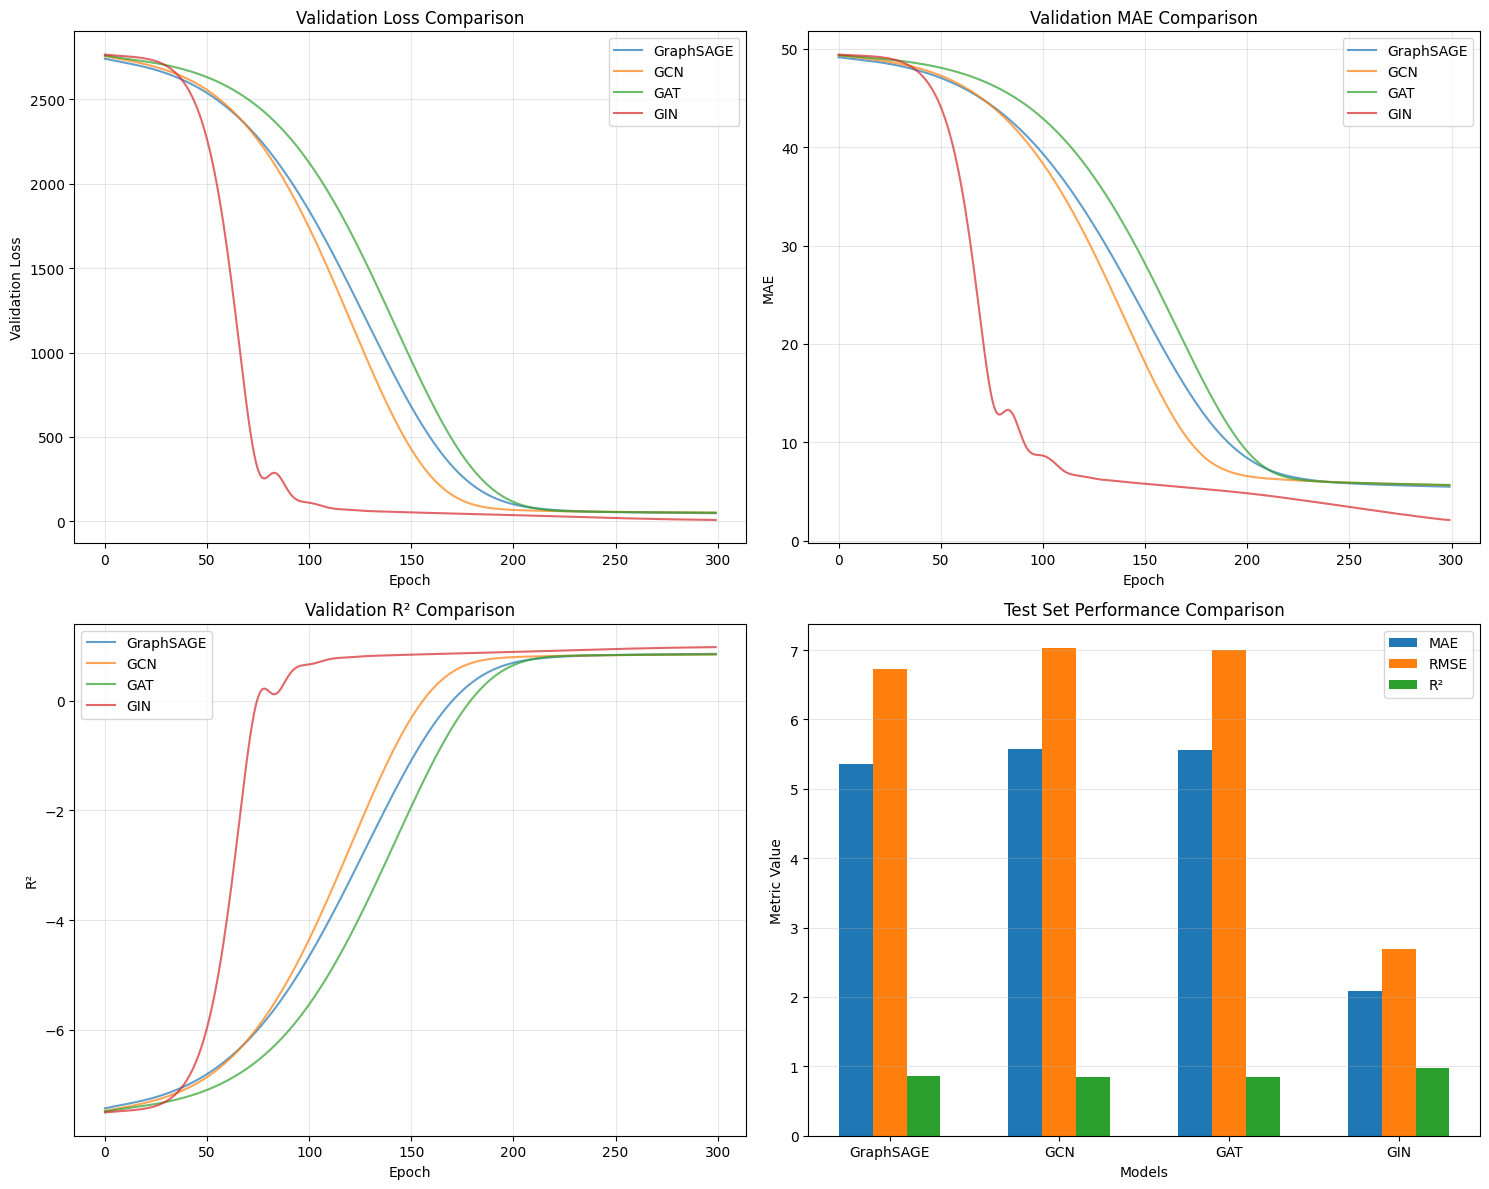


MODEL RANKING

MAE Ranking:
  1. GIN: 2.0858
  2. GraphSAGE: 5.3510
  3. GAT: 5.5668
  4. GCN: 5.5717

RMSE Ranking:
  1. GIN: 2.6878
  2. GraphSAGE: 6.7318
  3. GAT: 6.9997
  4. GCN: 7.0270

R2 Ranking:
  1. GIN: 0.9770
  2. GraphSAGE: 0.8555
  3. GAT: 0.8437
  4. GCN: 0.8425

PEARSON Ranking:
  1. GIN: 0.9891
  2. GraphSAGE: 0.9309
  3. GAT: 0.9308
  4. GCN: 0.9294


In [ ]:
import torch
import torch.nn as nn
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import pearsonr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def train_and_evaluate_model(model_class, model_name, data, device,
                             num_epochs=300, lr=0.001, patience=50):
    """
    Entraîne et évalue un modèle GNN

    Returns:
        dict: Résultats avec métriques et historique
    """
    print(f"\n{'='*60}")
    print(f"Training {model_name}")
    print(f"{'='*60}")

    # Initialiser le modèle
    model = model_class(data.x.shape[1]).to(device)
    data = data.to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=20
    )

    # Masques
    train_mask = data.train_mask
    val_mask = data.val_mask
    test_mask = data.test_mask

    # Training setup
    best_val_loss = float('inf')
    best_model_state = None
    patience_counter = 0

    history = {
        'train_loss': [],
        'val_loss': [],
        'val_mae': [],
        'val_r2': []
    }

    # Training loop
    for epoch in range(1, num_epochs + 1):
        # Train
        model.train()
        optimizer.zero_grad()
        train_pred = model(data)
        loss = loss_fn(train_pred[train_mask], data.y[train_mask])
        loss.backward()
        optimizer.step()

        # Evaluate
        model.eval()
        with torch.no_grad():
            eval_pred = model(data)

            val_pred = eval_pred[val_mask]
            val_true = data.y[val_mask]
            val_loss = loss_fn(val_pred, val_true).item()

            # Métriques validation
            val_mae = mean_absolute_error(
                val_true.cpu().numpy(),
                val_pred.cpu().numpy()
            )
            val_r2 = r2_score(
                val_true.cpu().numpy(),
                val_pred.cpu().numpy()
            ) if len(val_true) >= 2 else float('nan')

        # Store metrics
        history['train_loss'].append(loss.item())
        history['val_loss'].append(val_loss)
        history['val_mae'].append(val_mae)
        history['val_r2'].append(val_r2)

        # LR scheduling
        scheduler.step(val_loss)

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict().copy()
            patience_counter = 0
        else:
            patience_counter += 1

        # Print progress
        if epoch % 50 == 0 or epoch == 1:
            print(f"Epoch {epoch:03d} | Train Loss: {loss.item():.4f} | "
                  f"Val Loss: {val_loss:.4f} | Val MAE: {val_mae:.4f}")

        # Early stopping
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch}")
            break

    # Load best model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    # Final evaluation
    model.eval()
    with torch.no_grad():
        final_pred = model(data)

        # Train metrics
        train_pred = final_pred[train_mask]
        train_true = data.y[train_mask]
        train_mae = mean_absolute_error(train_true.cpu().numpy(), train_pred.cpu().numpy())
        train_rmse = np.sqrt(mean_squared_error(train_true.cpu().numpy(), train_pred.cpu().numpy()))
        train_r2 = r2_score(train_true.cpu().numpy(), train_pred.cpu().numpy())
        train_r, _ = pearsonr(train_true.cpu().numpy(), train_pred.cpu().numpy())

        # Val metrics
        val_pred = final_pred[val_mask]
        val_true = data.y[val_mask]
        val_mae = mean_absolute_error(val_true.cpu().numpy(), val_pred.cpu().numpy())
        val_rmse = np.sqrt(mean_squared_error(val_true.cpu().numpy(), val_pred.cpu().numpy()))
        val_r2 = r2_score(val_true.cpu().numpy(), val_pred.cpu().numpy())
        val_r, _ = pearsonr(val_true.cpu().numpy(), val_pred.cpu().numpy())

        # Test metrics
        test_pred = final_pred[test_mask]
        test_true = data.y[test_mask]
        test_mae = mean_absolute_error(test_true.cpu().numpy(), test_pred.cpu().numpy())
        test_rmse = np.sqrt(mean_squared_error(test_true.cpu().numpy(), test_pred.cpu().numpy()))
        test_r2 = r2_score(test_true.cpu().numpy(), test_pred.cpu().numpy())
        test_r, _ = pearsonr(test_true.cpu().numpy(), test_pred.cpu().numpy())

    print(f"\n{model_name} - Final Results:")
    print(f"Test: MAE={test_mae:.4f}, RMSE={test_rmse:.4f}, R²={test_r2:.4f}, Pearson r={test_r:.4f}")

    return {
        'model_name': model_name,
        'history': history,
        'metrics': {
            'train': {'mae': train_mae, 'rmse': train_rmse, 'r2': train_r2, 'pearson': train_r},
            'val': {'mae': val_mae, 'rmse': val_rmse, 'r2': val_r2, 'pearson': val_r},
            'test': {'mae': test_mae, 'rmse': test_rmse, 'r2': test_r2, 'pearson': test_r}
        },
        'best_epoch': epoch,
        'model_state': best_model_state
    }

# ==================== Exécution de la comparaison ====================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Dictionnaire des modèles à comparer
models_to_compare = {
    'GraphSAGE': HealthGNN_SAGE,
    'GCN': HealthGNN_GCN,
    'GAT': HealthGNN_GAT,
    'GIN': HealthGNN_GIN
}

# Entraîner tous les modèles
results = {}
for model_name, model_class in models_to_compare.items():
    results[model_name] = train_and_evaluate_model(
        model_class=model_class,
        model_name=model_name,
        data=data,
        device=device,
        num_epochs=300,
        lr=0.001,
        patience=50
    )

# ==================== Tableau comparatif ====================
print("\n" + "="*80)
print("COMPARATIVE RESULTS - TEST SET")
print("="*80)

comparison_df = pd.DataFrame({
    model_name: {
        'MAE': res['metrics']['test']['mae'],
        'RMSE': res['metrics']['test']['rmse'],
        'R²': res['metrics']['test']['r2'],
        'Pearson r': res['metrics']['test']['pearson'],
        'Best Epoch': res['best_epoch']
    }
    for model_name, res in results.items()
}).T

print(comparison_df.to_string())
print("="*80)

# Sauvegarder les résultats
comparison_df.to_csv('gnn_model_comparison.csv')
print("\nComparison saved to 'gnn_model_comparison.csv'")

# ==================== Visualisations comparatives ====================
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Validation Loss
ax = axes[0, 0]
for model_name, res in results.items():
    ax.plot(res['history']['val_loss'], label=model_name, alpha=0.7)
ax.set_xlabel('Epoch')
ax.set_ylabel('Validation Loss')
ax.set_title('Validation Loss Comparison')
ax.legend()
ax.grid(True, alpha=0.3)

# 2. Validation MAE
ax = axes[0, 1]
for model_name, res in results.items():
    ax.plot(res['history']['val_mae'], label=model_name, alpha=0.7)
ax.set_xlabel('Epoch')
ax.set_ylabel('MAE')
ax.set_title('Validation MAE Comparison')
ax.legend()
ax.grid(True, alpha=0.3)

# 3. Validation R²
ax = axes[1, 0]
for model_name, res in results.items():
    ax.plot(res['history']['val_r2'], label=model_name, alpha=0.7)
ax.set_xlabel('Epoch')
ax.set_ylabel('R²')
ax.set_title('Validation R² Comparison')
ax.legend()
ax.grid(True, alpha=0.3)

# 4. Bar plot des métriques finales
ax = axes[1, 1]
x = np.arange(len(models_to_compare))
width = 0.2
metrics_names = ['MAE', 'RMSE', 'R²']

for i, metric in enumerate(['mae', 'rmse', 'r2']):
    values = [results[name]['metrics']['test'][metric] for name in models_to_compare.keys()]
    ax.bar(x + i*width, values, width, label=metrics_names[i])

ax.set_xlabel('Models')
ax.set_ylabel('Metric Value')
ax.set_title('Test Set Performance Comparison')
ax.set_xticks(x + width)
ax.set_xticklabels(models_to_compare.keys())
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('gnn_models_comparison.png', dpi=300, bbox_inches='tight')
print("Comparison plot saved to 'gnn_models_comparison.png'")
plt.show()

# ==================== Statistical significance test (optionnel) ====================
print("\n" + "="*80)
print("MODEL RANKING")
print("="*80)

# Ranking par métrique
for metric in ['mae', 'rmse', 'r2', 'pearson']:
    metric_values = [(name, res['metrics']['test'][metric])
                     for name, res in results.items()]

    # Sort (ascending for MAE/RMSE, descending for R²/Pearson)
    reverse = metric in ['r2', 'pearson']
    sorted_models = sorted(metric_values, key=lambda x: x[1], reverse=reverse)

    print(f"\n{metric.upper()} Ranking:")
    for rank, (model, value) in enumerate(sorted_models, 1):
        print(f"  {rank}. {model}: {value:.4f}")



Improved visualisation

Using device: cpu

Training GraphSAGE
Epoch 001 | Train Loss: 2778.8145 | Val Loss: 2791.2783 | Val MAE: 49.8141 | Pearson: -0.5939
Epoch 050 | Train Loss: 2515.4138 | Val Loss: 2518.5303 | Val MAE: 47.0355 | Pearson: 0.0845
Epoch 100 | Train Loss: 1677.8464 | Val Loss: 1659.7980 | Val MAE: 37.4850 | Pearson: 0.6022
Epoch 150 | Train Loss: 463.9437 | Val Loss: 443.1187 | Val MAE: 18.5256 | Pearson: 0.8124
Epoch 200 | Train Loss: 88.4689 | Val Loss: 67.5363 | Val MAE: 6.5681 | Pearson: 0.8895
Epoch 250 | Train Loss: 72.1046 | Val Loss: 51.8575 | Val MAE: 5.6756 | Pearson: 0.9176
Epoch 300 | Train Loss: 64.8414 | Val Loss: 47.4627 | Val MAE: 5.4231 | Pearson: 0.9294

GraphSAGE - Final Results:
Test: MAE=5.3248, RMSE=6.7934, R²=0.8583, Pearson r=0.9321

Training GCN
Epoch 001 | Train Loss: 2774.5330 | Val Loss: 2787.0308 | Val MAE: 49.7971 | Pearson: 0.1118
Epoch 050 | Train Loss: 2658.3672 | Val Loss: 2668.1880 | Val MAE: 48.5721 | Pearson: -0.1289
Epoch 100 | Train Loss: 2239.8982 | Val

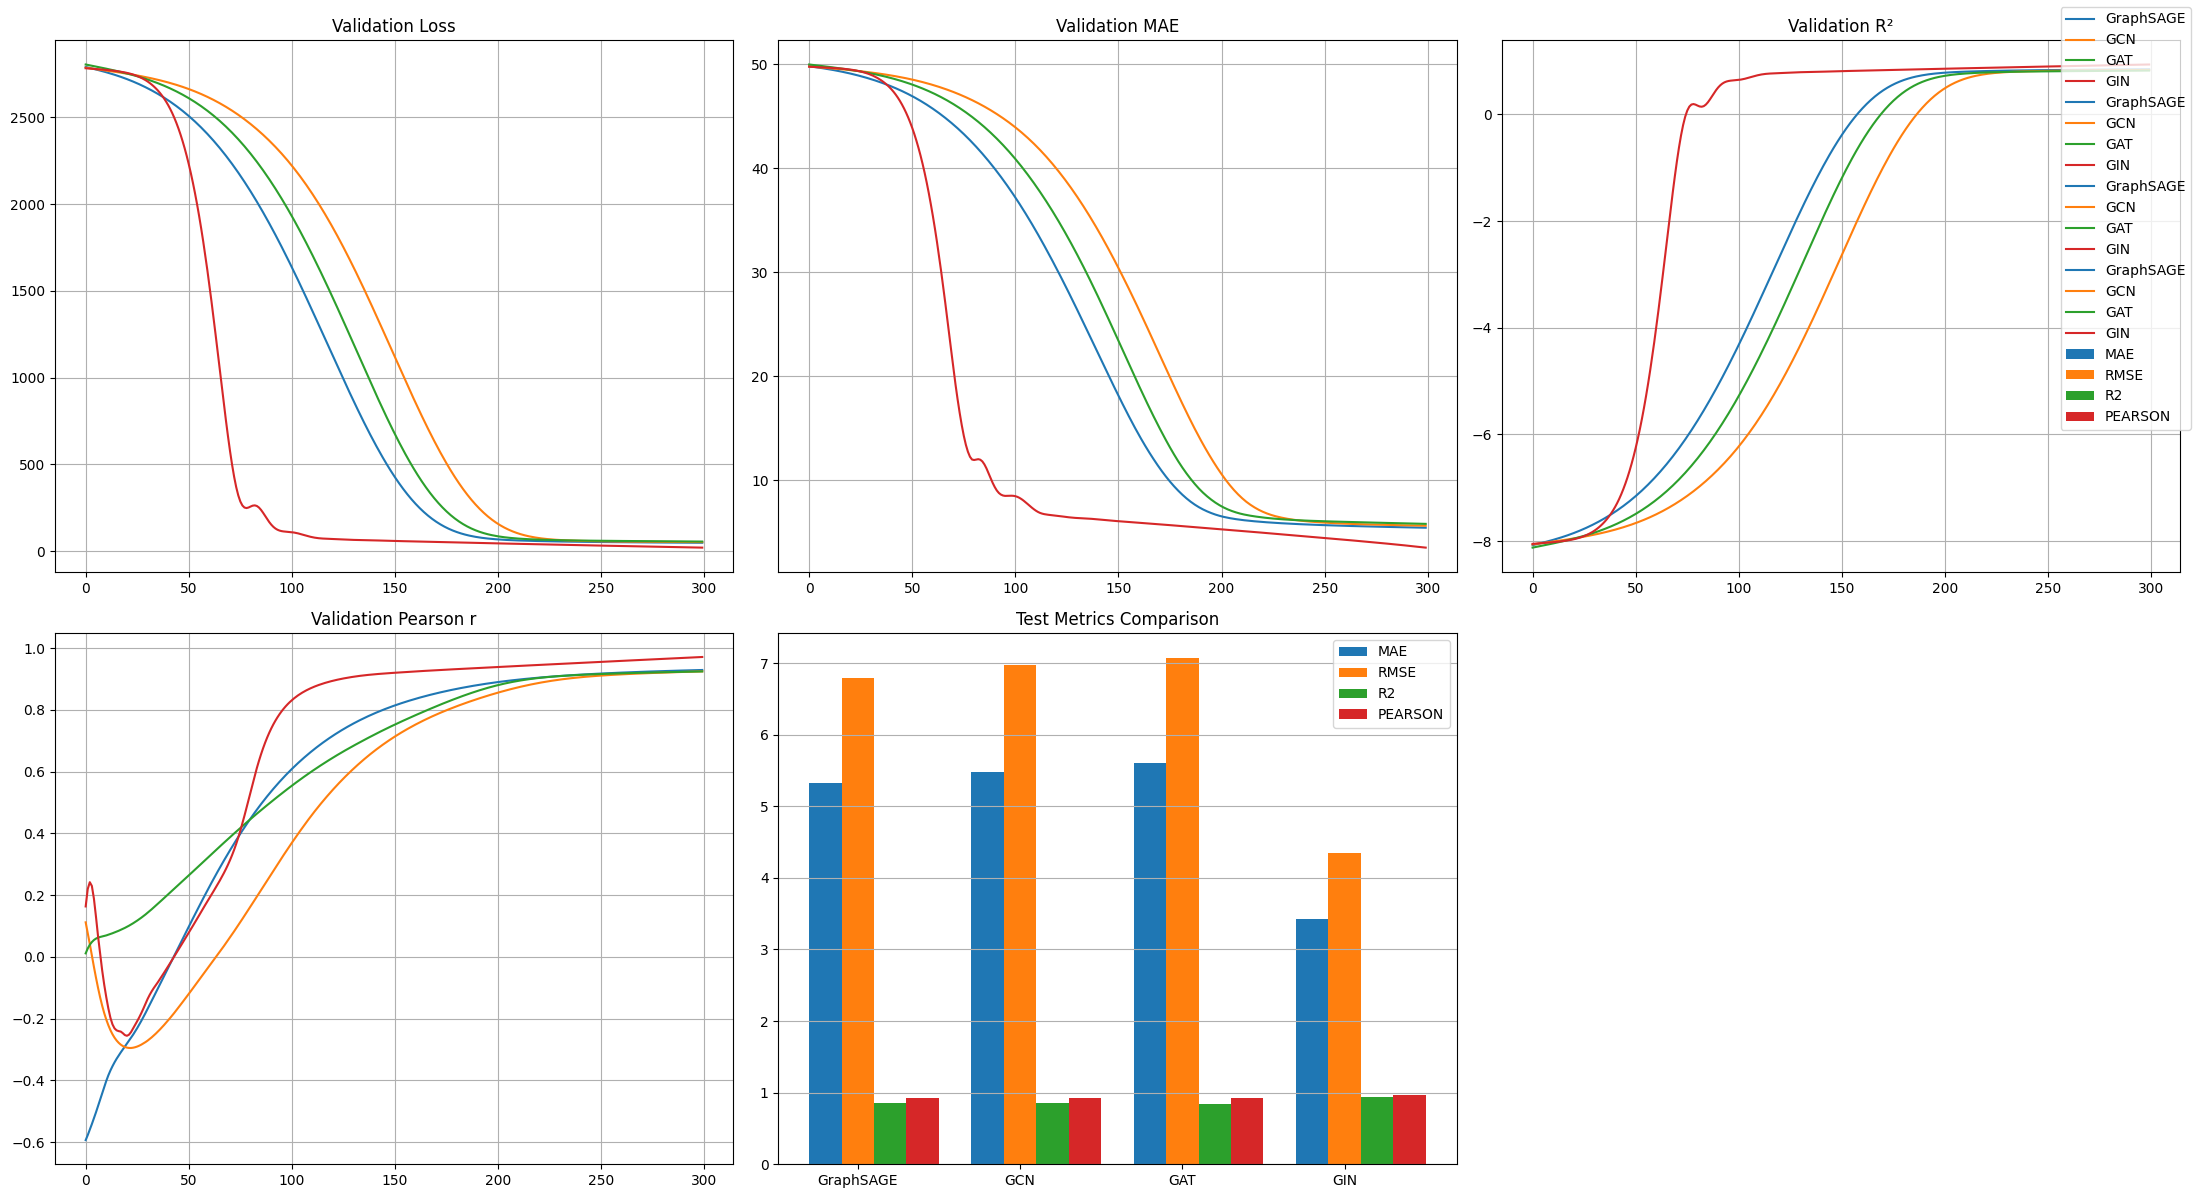

In [ ]:
import torch
import torch.nn as nn
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import pearsonr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def train_and_evaluate_model(model_class, model_name, data, device,
                             num_epochs=300, lr=0.001, patience=50):

    print(f"\n{'='*60}")
    print(f"Training {model_name}")
    print(f"{'='*60}")

    model = model_class(data.x.shape[1]).to(device)
    data = data.to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=20
    )

    train_mask = data.train_mask
    val_mask = data.val_mask
    test_mask = data.test_mask

    best_val_loss = float('inf')
    best_model_state = None
    patience_counter = 0

    # Ajout de Pearson dans l'historique
    history = {
        'train_loss': [],
        'val_loss': [],
        'val_mae': [],
        'val_r2': [],
        'val_pearson': []       # <-- ajouté
    }

    # Training loop
    for epoch in range(1, num_epochs + 1):
        model.train()
        optimizer.zero_grad()
        train_pred = model(data)
        loss = loss_fn(train_pred[train_mask], data.y[train_mask])
        loss.backward()
        optimizer.step()

        # Validation
        model.eval()
        with torch.no_grad():
            eval_pred = model(data)
            val_pred = eval_pred[val_mask]
            val_true = data.y[val_mask]

            val_loss = loss_fn(val_pred, val_true).item()
            val_mae = mean_absolute_error(val_true.cpu().numpy(), val_pred.cpu().numpy())
            val_r2 = r2_score(val_true.cpu().numpy(), val_pred.cpu().numpy()) if len(val_true) >= 2 else float('nan')

            # Pearson r
            if len(val_true) > 1:
                val_r, _ = pearsonr(val_true.cpu().numpy(), val_pred.cpu().numpy())
            else:
                val_r = float('nan')

        # Store
        history['train_loss'].append(loss.item())
        history['val_loss'].append(val_loss)
        history['val_mae'].append(val_mae)
        history['val_r2'].append(val_r2)
        history['val_pearson'].append(val_r)

        # Early stopping
        scheduler.step(val_loss)
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict().copy()
            patience_counter = 0
        else:
            patience_counter += 1

        if epoch % 50 == 0 or epoch == 1:
            print(f"Epoch {epoch:03d} | Train Loss: {loss.item():.4f} | "
                  f"Val Loss: {val_loss:.4f} | Val MAE: {val_mae:.4f} | Pearson: {val_r:.4f}")

        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch}")
            break

    # Load best model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    # Final evaluation
    model.eval()
    with torch.no_grad():
        final_pred = model(data)

        # Compute all metrics for train, val, test
        def compute_metrics(true, pred):
            mae = mean_absolute_error(true, pred)
            rmse = np.sqrt(mean_squared_error(true, pred))
            r2 = r2_score(true, pred)
            r, _ = pearsonr(true, pred)
            return mae, rmse, r2, r

        train_mae, train_rmse, train_r2, train_r = compute_metrics(
            data.y[train_mask].cpu().numpy(),
            final_pred[train_mask].cpu().numpy()
        )
        val_mae, val_rmse, val_r2, val_r = compute_metrics(
            data.y[val_mask].cpu().numpy(),
            final_pred[val_mask].cpu().numpy()
        )
        test_mae, test_rmse, test_r2, test_r = compute_metrics(
            data.y[test_mask].cpu().numpy(),
            final_pred[test_mask].cpu().numpy()
        )

    print(f"\n{model_name} - Final Results:")
    print(f"Test: MAE={test_mae:.4f}, RMSE={test_rmse:.4f}, R²={test_r2:.4f}, Pearson r={test_r:.4f}")

    return {
        'model_name': model_name,
        'history': history,
        'metrics': {
            'train': {'mae': train_mae, 'rmse': train_rmse, 'r2': train_r2, 'pearson': train_r},
            'val': {'mae': val_mae, 'rmse': val_rmse, 'r2': val_r2, 'pearson': val_r},
            'test': {'mae': test_mae, 'rmse': test_rmse, 'r2': test_r2, 'pearson': test_r}
        },
        'best_epoch': epoch,
        'model_state': best_model_state
    }


# ==================== Exécution de la comparaison ====================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

models_to_compare = {
    'GraphSAGE': HealthGNN_SAGE,
    'GCN': HealthGNN_GCN,
    'GAT': HealthGNN_GAT,
    'GIN': HealthGNN_GIN
}

results = {}
for model_name, model_class in models_to_compare.items():
    results[model_name] = train_and_evaluate_model(
        model_class=model_class,
        model_name=model_name,
        data=data,
        device=device,
        num_epochs=300,
        lr=0.001,
        patience=50
    )

# ==================== Visualisation : 2 × 3 avec Pearson ====================
fig, axes = plt.subplots(2, 3, figsize=(22, 12))

# 1. Validation Loss
ax = axes[0, 0]
for name, res in results.items():
    ax.plot(res['history']['val_loss'], label=name)
ax.set_title("Validation Loss")
ax.grid(True)

# 2. Validation MAE
ax = axes[0, 1]
for name, res in results.items():
    ax.plot(res['history']['val_mae'], label=name)
ax.set_title("Validation MAE")
ax.grid(True)

# 3. Validation R²
ax = axes[0, 2]
for name, res in results.items():
    ax.plot(res['history']['val_r2'], label=name)
ax.set_title("Validation R²")
ax.grid(True)

# 4. Validation Pearson r
ax = axes[1, 0]
for name, res in results.items():
    ax.plot(res['history']['val_pearson'], label=name)
ax.set_title("Validation Pearson r")
ax.grid(True)

# 5. Bar plot metrics (MAE / RMSE / R² / Pearson)
ax = axes[1, 1]
x = np.arange(len(models_to_compare))
width = 0.2
metrics = ["mae","rmse","r2","pearson"]

for i, metric in enumerate(metrics):
    values = [results[m]["metrics"]["test"][metric] for m in models_to_compare.keys()]
    ax.bar(x + i*width, values, width, label=metric.upper())

ax.set_xticks(x + width)
ax.set_xticklabels(models_to_compare.keys())
ax.set_title("Test Metrics Comparison")
ax.legend()
ax.grid(axis="y")

# 6. Empty or global legend
axes[1, 2].axis("off")
fig.legend(loc="upper right")

plt.tight_layout()
plt.savefig("gnn_all_metrics.png", dpi=300)



KeyError: 'val_pearson'

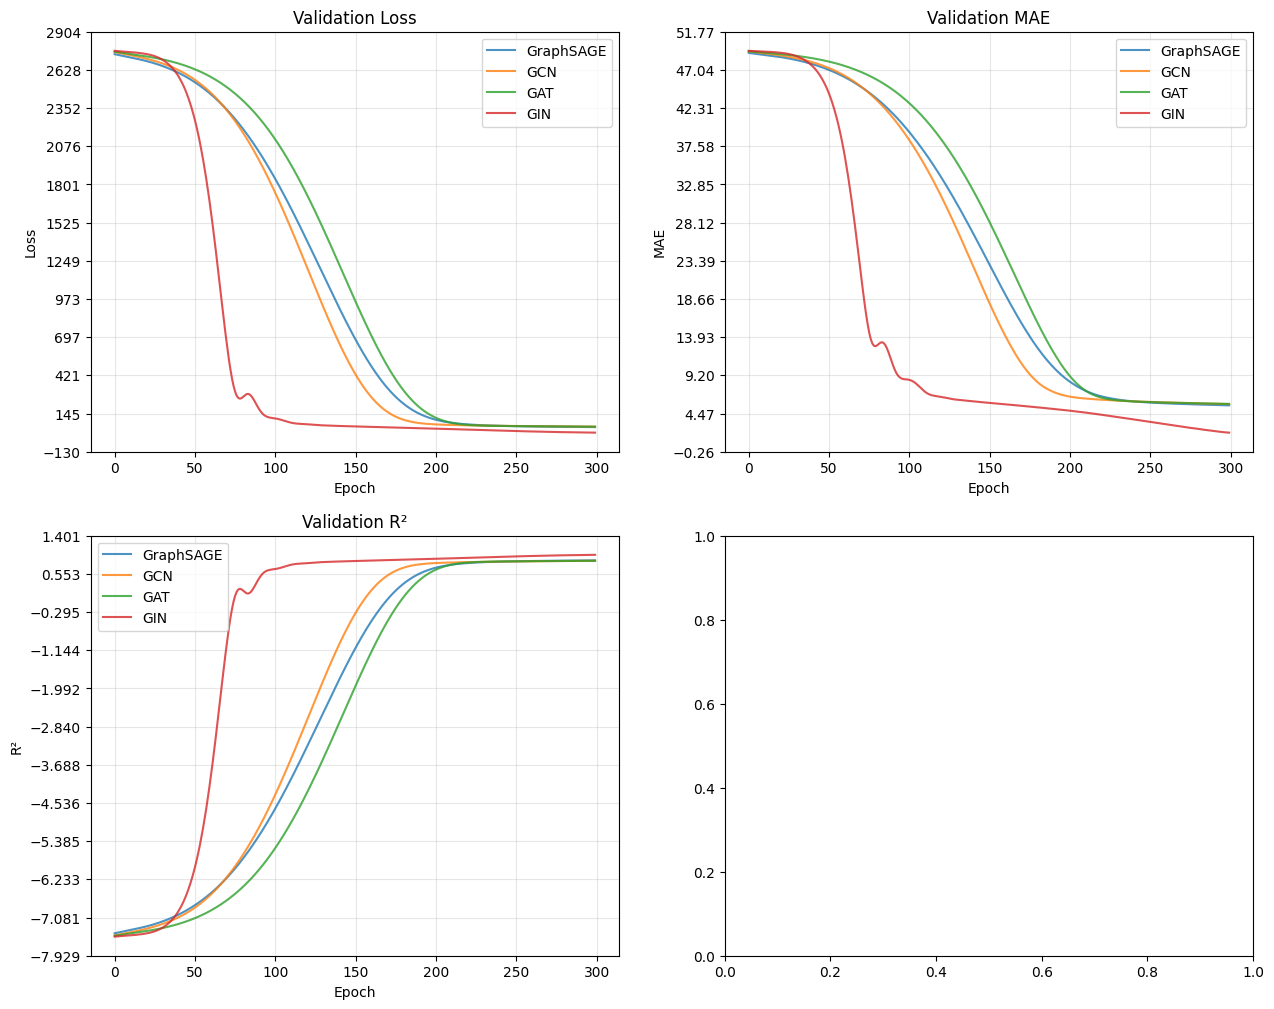

In [ ]:
# ==================== Validation Metrics (2x2) ====================
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Loss
ax = axes[0, 0]
for name, res in results.items():
    ax.plot(res['history']['val_loss'], label=name, alpha=0.8)
ax.set_title("Validation Loss")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.grid(True, alpha=0.3)
ax.legend()
ax.set_yticks(np.linspace(ax.get_ylim()[0], ax.get_ylim()[1], 12))

# MAE
ax = axes[0, 1]
for name, res in results.items():
    ax.plot(res['history']['val_mae'], label=name, alpha=0.8)
ax.set_title("Validation MAE")
ax.set_xlabel("Epoch")
ax.set_ylabel("MAE")
ax.grid(True, alpha=0.3)
ax.legend()
ax.set_yticks(np.linspace(ax.get_ylim()[0], ax.get_ylim()[1], 12))

# R²
ax = axes[1, 0]
for name, res in results.items():
    ax.plot(res['history']['val_r2'], label=name, alpha=0.8)
ax.set_title("Validation R²")
ax.set_xlabel("Epoch")
ax.set_ylabel("R²")
ax.grid(True, alpha=0.3)
ax.legend()
ax.set_yticks(np.linspace(ax.get_ylim()[0], ax.get_ylim()[1], 12))

# Pearson
ax = axes[1, 1]
for name, res in results.items():
    ax.plot(res['history']['val_pearson'], label=name, alpha=0.8)
ax.set_title("Validation Pearson r")
ax.set_xlabel("Epoch")
ax.set_ylabel("Pearson r")
ax.grid(True, alpha=0.3)
ax.legend()
ax.set_yticks(np.linspace(ax.get_ylim()[0], ax.get_ylim()[1], 12))

plt.tight_layout()
plt.savefig("validation_metrics.png", dpi=350, bbox_inches="tight")
plt.show()


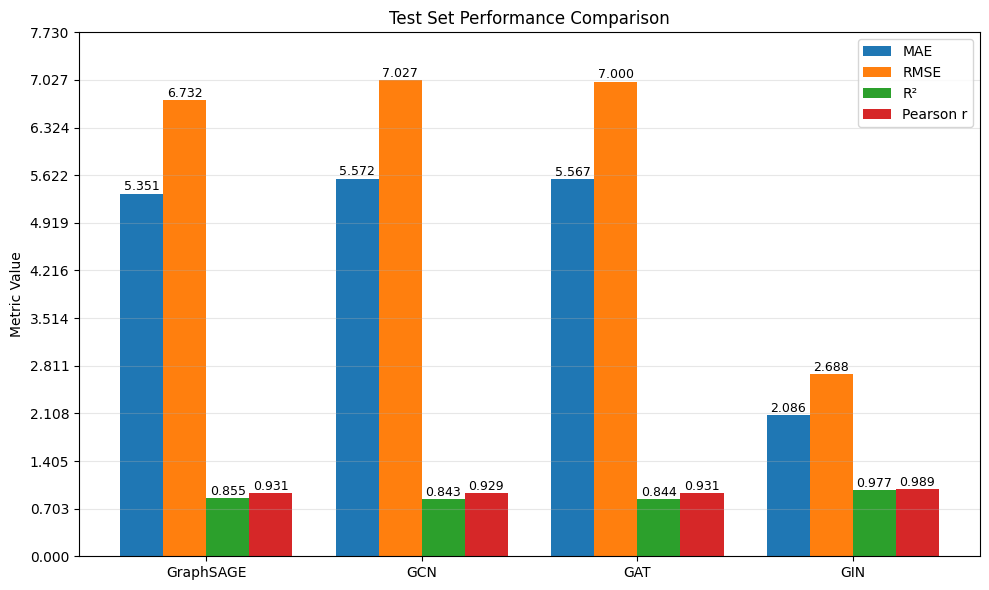

In [ ]:
# ==================== Test Metrics (Bar Plot) ====================
models = list(models_to_compare.keys())
x = np.arange(len(models))
width = 0.2

metrics = ['mae', 'rmse', 'r2', 'pearson']
labels = ['MAE', 'RMSE', 'R²', 'Pearson r']

plt.figure(figsize=(10, 6))
for i, metric in enumerate(metrics):
    values = [results[m]['metrics']['test'][metric] for m in models]
    plt.bar(x + i*width, values, width, label=labels[i])
    # Add value labels
    for j, v in enumerate(values):
        plt.text(x[j] + i*width, v + 0.005, f"{v:.3f}", ha='center', va='bottom', fontsize=9)

plt.xticks(x + width*1.5, models)
plt.ylabel("Metric Value")
plt.title("Test Set Performance Comparison")
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.yticks(np.linspace(0, max(max([results[m]['metrics']['test'][metric] for m in models]) for metric in metrics)*1.1, 12))
plt.tight_layout()
plt.savefig("test_metrics.png", dpi=350, bbox_inches="tight")
plt.show()
